In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from WordToVector import *
import numpy as np
from embeddingDataset import *

C:\Users\User\anaconda3\envs\4211\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_pickle(r'resources\\analytics_challenge_dataset_ex211008.pkl')
# data2 = pd.read_pickle(r'resources\\sample_data.pkl')
data

,docid,comment_count,like_count,dislike_count,love_count,haha_count,wow_count,angry_count,sad_count,share_count,view_count,headline,author*,pubname,pubdate,region,fans_count,author_type,content
0,2020021100002988743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,黃佩君,2b6b5092d1013c7be4b9cf77f33df8f2,Facebook - 群組 或專頁,43872.001076,Hong Kong,0.0,網紅博客,\n=====Shared Post=====\n 宣佈強制檢疫 政府留兩天半空窗期 入境...
1,2020021100000087375,9.0,57.0,NaN,0.0,0.0,1.0,0.0,6.0,8.0,0.0,近日多左人講大陸可能大亂。當然我早兩個禮拜已經從多方面分析過大陸可能出現經濟、社會、政治問題...,d7b198555346a8567a7bbc2a5c808fea,Facebook - 群組 或專頁,43872.001377,Hong Kong,3133.0,網紅博客,近日多左人講大陸可能大亂。當然我早兩個禮拜已經從多方面分析過大陸可能出現經濟、社會、政治問題...
2,2020021100000051790,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,221.0,關愛香港，情繫中華！,77c0271fe5557f54dc91ab4d1feb0117,Facebook - 群組 或專頁,43872.001412,Hong Kong,18197.0,網民,\n=====Shared Post=====\n 人間有情 人間總充滿溫暖 !彩虹始終...
3,2020021100000098619,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,【武漢肺炎・最新】單日新增6宗個案 本港累計42宗,NaN,香港01,43872.002083,NaN,NaN,NaN,2020-02-10 07:07\n\n新型冠狀病毒引起的武漢肺炎病情持續，國家衛健委今日(...
4,2020021100000006742,14.0,21.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,新加坡嚴打違反隔離令人士 處分6僱主 4人被罰永久禁止在當地工作,eee801ed705bc0f540806efac44e2591,香港高登,43872.002083,NaN,NaN,網民,\n新加坡確診新型冠狀病毒肺炎的人數周日增至43宗，是繼日本後，中國境外最多人確診的地區，在...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444276,2021072921783889037,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2019冠狀病毒病（俗稱新冠肺炎）疫情肆虐全球已超過一年半，但病毒依然對人類的日常生活帶來重...,bbabacaacf93a4cbc209feebcb304f5f,Facebook香港,44406.978380,Hong Kong,370.0,機構及社群,2019冠狀病毒病（俗稱新冠肺炎）疫情肆虐全球已超過一年半，但病毒依然對人類的日常生活帶來重...
444277,2021072921782399780,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,英國今日117人死於新冠肺炎，其中50人打齊兩就英國疫苗阿斯利康！！,da3e5324ece427171d69a76671266fc7,LIHKG,44406.986701,NaN,NaN,網民,NaN
444278,2021072921787915332,14.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,疫下封關跨境婚姻告吹 中港婚姻宗數大跌逾70%,b89a65490639fcf96e341a4ab7982d6b,香港討論區-discuss.com.hk,44406.989583,NaN,NaN,網民,\n新冠肺炎疫情肆虐多時，令不少中港婚姻無法成事。統計處最新一份《香港的女性及男性 - 主要...
444279,2021072921782679128,5.0,18.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,呢個答法，似乎可能性都唔細 全文：https://bit.ly/3f8Twwm 接收最快疫情...,9a991621015589132eeddb50204c8c60,Facebook香港,44406.989606,Hong Kong,389352.0,媒體,呢個答法，似乎可能性都唔細 全文：https://bit.ly/3f8Twwm 接收最快疫情...


In [4]:
data = data[data['pubname'] == 'Facebook香港' ]

In [5]:
data = data[['content', 'like_count']]

In [6]:
data.dropna(subset=['content'], inplace=True)
data = data[(data['like_count'] > 30) & (data['like_count'] < 400)]
data.reset_index(inplace=True)
data = data.head(60000)
data

,index,content,like_count
0,57817,霍詠強 美國星島中文電台 時事觀察 2020-03-18 第1節：香港應引入國家安全法、港...,54.0
1,57821,【林鄭月娥視察機場口岸強制檢疫措施及2個檢測中心】 【香港商報訊】行政長官林鄭月娥今日下午到...,172.0
2,57824,繼上次新蒲崗良心店聯合搞咗個「全民抗疫包」（派W達紙巾嗰次）後，今次仲加埋理大畢業生聯同香港...,111.0
3,57851,\n=====Shared Post=====\n 【貝爾特酒店住客確診，酒店餐廳照常營...,56.0
4,57854,【緊貼 01新聞】湯家驊又批評袁國勇在中國的「傷口上撒鹽」 全文：http://bit.ly...,351.0
...,...,...,...
59995,378205,【緊貼 01新聞】趁火打劫嘅行為，只會令客人繼續流失呀 全文：https://bit.ly/...,43.0
59996,378218,仲有買多啲唔一定抵啲㗎！ 全文：https://bit.ly/3ljWD6u 接收最快疫情警...,33.0
59997,378234,這些人甘願做別國的棋子，越走越遠，今生玩完。 【境外勢力】羅冠聰許智峯等8逃亡港人發起《香港...,65.0
59998,378236,女童一死一失蹤，呢個母女掉包好似電影情節咁 全文︰https://bit.ly/3eI1ah...,33.0


In [7]:
np.random.seed(112)
df_train, df_val, df_test = np.split(data.sample(frac=1, random_state=42), [int(0.8*len(data)), int(0.9*len(data))])

print(len(df_train),len(df_val), len(df_test))

48000 6000 6000


In [8]:
train_embeddings = transformer_(df_train)
val_embeddings = transformer_(df_val)
test_embeddings = transformer_(df_test)

In [9]:
batch_size = 32
target = 'like_count'
train, val = Dataset_embedding(df_train, train_embeddings, target), Dataset_embedding(df_val, val_embeddings, target)

train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

In [10]:
class model(nn.Module):
    def __init__(self, dropout=0.5):
        
        super(model, self).__init__()
        self.layers = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(train_embeddings.shape[1], 500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.ReLU(),
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)



In [11]:
acc_train_lst, acc_val_lst, loss_train_lst, loss_val_lst = [], [], [], []
device = 'cuda:0'

mlp = model()
mlp = mlp.cuda()
loss_function = nn.L1Loss()
loss_function = loss_function.cuda()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.00001)

In [12]:
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

In [13]:
for epoch in range(0, 5):
    print(f'Starting epoch {epoch+1}')
    loss_train = 0
    
    for inputs, targets in tqdm(train_dataloader):
        targets = targets.type(torch.LongTensor)
        targets = targets.reshape(-1,1).to(device)
        inputs = inputs.to(device)

        
        output = mlp.forward(inputs)

        loss = loss_function(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.item()

    val_loss = 0
    val_mse = 0

    with torch.no_grad():
        for val_input, val_label in val_dataloader:

            val_label = val_label.type(torch.LongTensor)
            val_label = val_label.reshape(-1,1).to('cuda:0')
            val_input = val_input.to('cuda:0')
            
            val_output = mlp(val_input)
            loss = loss_function(val_output, val_label)
            val_loss += loss
            
    tot_train_loss = loss_train / len(train_dataloader)
    tot_val_loss = val_loss / len(val_dataloader)

    print(f"| Training loss:   {tot_train_loss: .3f} | ")
    print(f"| Validation loss: {tot_val_loss: .3f} | ")

    loss_train_lst.append(tot_train_loss)
    loss_val_lst.append(tot_val_loss)




Starting epoch 1


100%|██████████| 1500/1500 [00:04<00:00, 363.64it/s]


| Training loss:    103.603 | 
| Validation loss:  81.077 | 
Starting epoch 2


100%|██████████| 1500/1500 [00:04<00:00, 346.34it/s]


| Training loss:    63.090 | 
| Validation loss:  60.319 | 
Starting epoch 3


100%|██████████| 1500/1500 [00:04<00:00, 349.24it/s]


| Training loss:    60.069 | 
| Validation loss:  60.374 | 
Starting epoch 4


100%|██████████| 1500/1500 [00:04<00:00, 346.82it/s]


| Training loss:    60.004 | 
| Validation loss:  60.349 | 
Starting epoch 5


100%|██████████| 1500/1500 [00:04<00:00, 351.45it/s]


| Training loss:    59.926 | 
| Validation loss:  60.189 | 


In [25]:
print(data.like_count.std())
print(data.like_count.mean())

85.14232877338749
110.32871666666666


array([[<AxesSubplot:title={'center':'like_count'}>]], dtype=object)

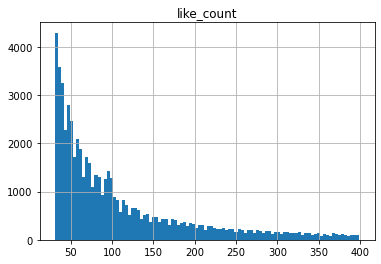

In [26]:
data[(data['like_count'] >30) & (data['like_count'] < 400)].hist('like_count', bins=100)